In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
gpp_data = xr.open_dataset("./gpp_Lmon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc")["gpp"]
cveg_data = xr.open_dataset("./cVeg_Lmon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc")["cVeg"]
ts_data = xr.open_dataset("./ts_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc")["ts"]
hurs_data = xr.open_dataset("./hurs_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc")["hurs"]
pr_data = xr.open_dataset("./pr_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc")["pr"]

In [3]:
start_x = 12*(1880-1850)
end_x = 12*(1900-1850)
start_y = 12*(1980-1850)
end_y = 12*(2000-1850)

def avg20(ds):
    return np.mean(ds.to_numpy(), axis=0) # axis of mean = time

In [4]:
x_cveg = avg20(cveg_data[start_x:end_x,:,:])
x_ts = avg20(ts_data[start_x:end_x,:,:])
x_pr = avg20(pr_data[start_x:end_x,:,:])
y_ts = avg20(ts_data[start_y:end_y,:,:])
y_pr = avg20(pr_data[start_y:end_y,:,:])
y_cveg = avg20(cveg_data[start_y:end_y,:,:])
delta_ts = y_ts - x_ts
delta_pr = y_pr - x_pr
delta_cveg = y_cveg - x_cveg

mask = x_cveg > 0

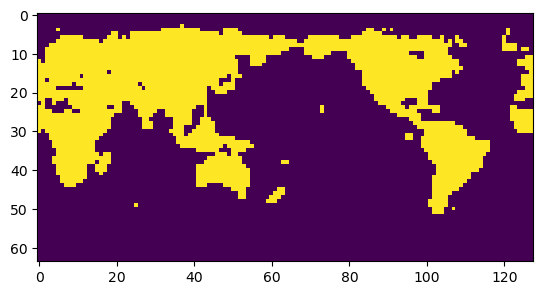

In [5]:
plt.imshow(mask[::-1])

Text(0.5, 1.0, '100 year change cVeg')

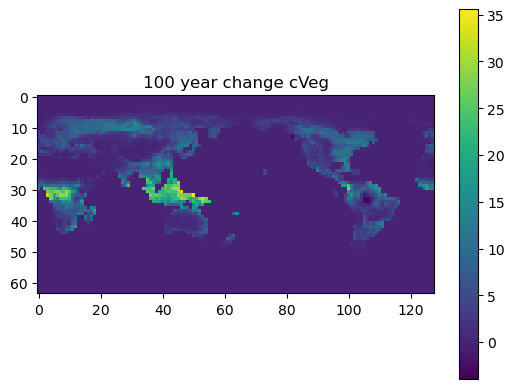

In [6]:
plt.imshow(delta_cveg[::-1])
plt.colorbar()
plt.title("100 year change cVeg")

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
def plot_and_test(input, output, mask,color=None,ax=plt):
    output = output[mask].flatten()
    input = input[mask].flatten()
    
    ax.scatter(input, output, alpha=0.2, color=color)

def fit_and_test(inputs, output, mask):
    output = output[mask].flatten()
    for i in range(len(inputs)):
        inputs[i] = inputs[i][mask].flatten()
    inputs = np.array(inputs).transpose()
    
    model = LinearRegression()
    model.fit(inputs, output)

    R2 = model.score(inputs, output)
    
    print("*", model.coef_, "+", model.intercept_, "    R^2", R2)
    return model

Text(0, 0.5, 'delta cVeg')

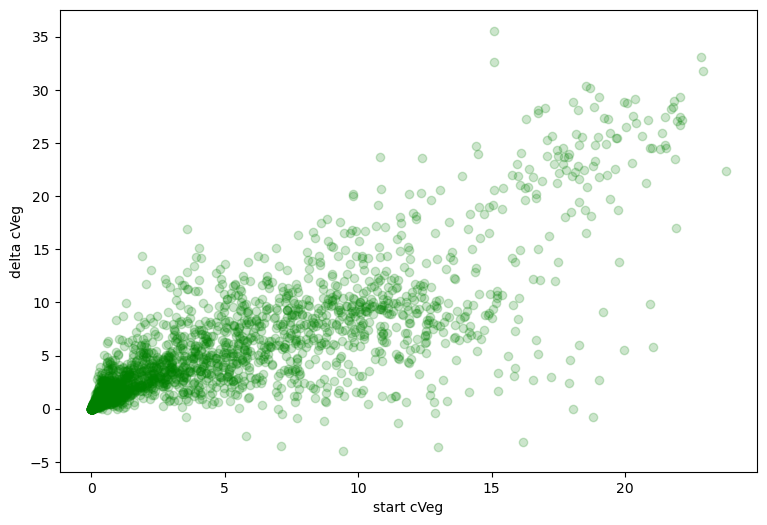

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plot_and_test(x_cveg, delta_cveg, mask, ax=ax, color="g")
ax.set_xlabel("start cVeg")
ax.set_ylabel("delta cVeg")

Text(0, 0.5, 'Delta Precip.')

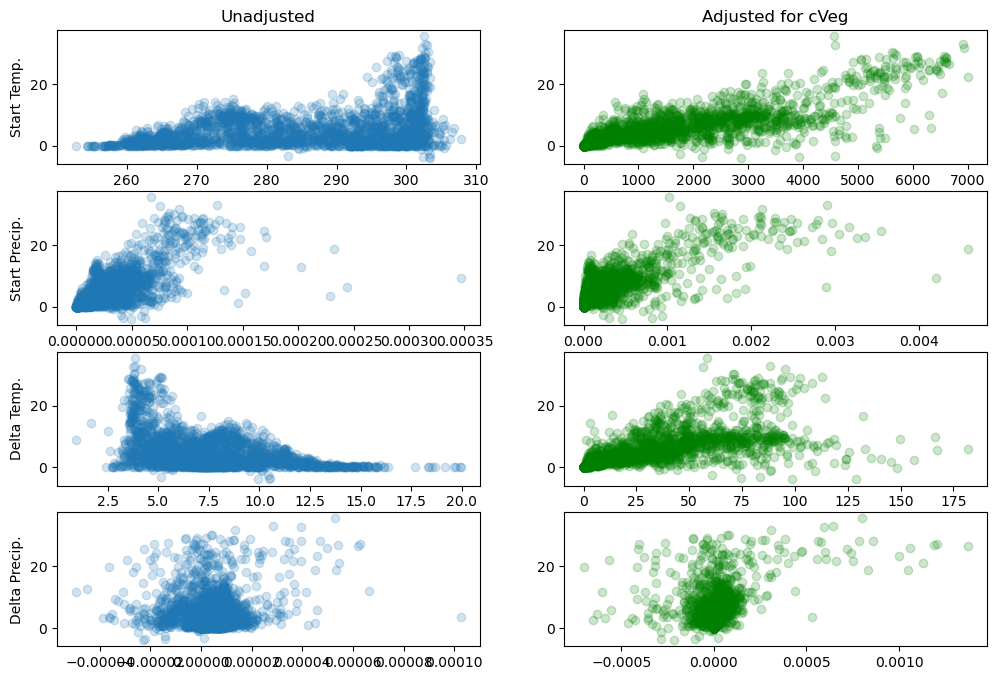

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(12, 8))

fig_d = [
    [x_ts,x_pr,delta_ts,delta_pr],
    [x_ts*x_cveg,x_pr*x_cveg,delta_ts*x_cveg,delta_pr*x_cveg]
]

fig_c = [None, "g"]

for x in (0,1):
    for y in (0,1,2,3):
        plot_and_test(fig_d[x][y], delta_cveg, mask,ax=axs[y][x], color=fig_c[x])
axs[0][0].set_title("Unadjusted")
axs[0][1].set_title("Adjusted for cVeg")
axs[0][0].set_ylabel("Start Temp.")
axs[1][0].set_ylabel("Start Precip.")
axs[2][0].set_ylabel("Delta Temp.")
axs[3][0].set_ylabel("Delta Precip.")

In [11]:
fit_and_test([x_cveg, x_ts, x_pr, delta_ts, delta_pr], delta_cveg, mask)

* [ 7.67853975e-01  5.88819385e-04  3.32850586e+04 -1.51384652e-01
  1.21294055e+05] + 1.1006236     R^2 0.7182865069908551


LinearRegression()

In [12]:
fit_and_test([x_cveg], delta_cveg, mask)

* [0.9168896] + 0.8546896     R^2 0.6599437612113042


LinearRegression()

In [13]:
fit_and_test([x_cveg, 
              x_ts,
              x_pr,
              delta_ts,
              delta_pr,
              x_ts * x_cveg, 
              x_pr * x_cveg, 
              delta_ts * x_cveg, 
              delta_pr * x_cveg], delta_cveg, mask)

* [ 5.54016009e-02 -6.97207898e-02  1.10515144e+02 -2.31831655e-01
  2.14778233e+01  3.93731892e-03  2.01085364e+03 -8.48754272e-02
  3.39666504e+02] + 23.040783     R^2 0.7250339374121711


LinearRegression()

In [14]:
fit_and_test([x_cveg, delta_ts * x_cveg, delta_pr * x_cveg], delta_cveg, mask)

* [ 1.4085248e+00 -9.9409483e-02  7.3809907e+03] + 1.2985518     R^2 0.7319914368305154


LinearRegression()

In [15]:
fit_and_test([x_cveg, x_ts * x_cveg, x_pr * x_cveg], delta_cveg, mask)

* [-1.3821696e+00  7.0090163e-03  2.9060244e+03] + 1.360141     R^2 0.6911165235498931


LinearRegression()

In [16]:
fit_and_test([x_cveg, 
              x_ts,
              x_pr,
              delta_ts,
              delta_pr,
              delta_ts * x_cveg, 
              delta_pr * x_cveg], delta_cveg, mask)

* [ 1.3607996e+00 -7.6908469e-03  1.8292812e+04 -1.6712749e-03
  9.0633398e+04 -9.4443589e-02  8.5374670e+02] + 2.7753572     R^2 0.7446845835499989


LinearRegression()

In [26]:
fit_and_test([x_cveg, delta_ts * x_cveg, delta_pr], delta_cveg, mask)

* [ 1.4713563e+00 -1.0181683e-01  1.0226260e+05] + 0.76233196     R^2 0.7418762228071839


LinearRegression()

In [31]:
fit_and_test([x_cveg, delta_ts * x_cveg, x_pr], delta_cveg, mask)

* [-2.9947836e+00  1.3218330e-02  8.6815839e-05] + 1.1615071     R^2 0.6800239726942294


LinearRegression()

In [17]:
gpp_data.lat.to_numpy()

array([-87.86379884, -85.09652699, -82.31291295, -79.52560657,
       -76.73689968, -73.94751515, -71.15775201, -68.36775611,
       -65.57760701, -62.7873518 , -59.99702011, -57.20663153,
       -54.41619953, -51.62573367, -48.83524097, -46.04472663,
       -43.25419467, -40.46364818, -37.67308963, -34.88252099,
       -32.09194388, -29.30135962, -26.51076933, -23.72017393,
       -20.92957425, -18.13897099, -15.34836476, -12.55775612,
        -9.76714556,  -6.97653355,  -4.18592053,  -1.39530691,
         1.39530691,   4.18592053,   6.97653355,   9.76714556,
        12.55775612,  15.34836476,  18.13897099,  20.92957425,
        23.72017393,  26.51076933,  29.30135962,  32.09194388,
        34.88252099,  37.67308963,  40.46364818,  43.25419467,
        46.04472663,  48.83524097,  51.62573367,  54.41619953,
        57.20663153,  59.99702011,  62.7873518 ,  65.57760701,
        68.36775611,  71.15775201,  73.94751515,  76.73689968,
        79.52560657,  82.31291295,  85.09652699,  87.86

In [18]:
# Choose r to make sphere surface area 1 for easy multiplication later
# r = sqrt(1/4pi)
r = np.sqrt(1/(4*np.pi))

# Gets height of section of sphere given two angles
def getH(angles):
    angle_min = np.min(angles)
    angle_max = np.max(angles)
    
    # Hypotenuse = r
    # Hypotenuse * sin(Theta) = Opposite
    h_min = r * np.sin(angle_min)
    h_max = r * np.sin(angle_max)
    return h_max - h_min

# https://en.wikipedia.org/wiki/Spherical_segment
def getArea(horizontal_angles,vertical_angles,in_degrees=True):
    if in_degrees: # We need radians
        horizontal_angles *= (np.pi / 180)
        vertical_angles *= (np.pi / 180)

    left_bound = np.min(horizontal_angles)
    right_bound = np.max(horizontal_angles)
    arc_horz = right_bound - left_bound

    # 2 * pi * r * h * arc2
    return 2 * np.pi * r * getH(vertical_angles) * (arc_horz/(2*np.pi))

# should theoretically equal 1
getArea(np.array([-180,180], dtype=np.float64),np.array([90,-90], dtype=np.float64))

0.9999999999999999

In [19]:
def cuts(amount_vertical,amount_horizontal,vstart=90):
    space = np.linspace(-vstart,vstart,amount_vertical+1)
    width = 360/amount_horizontal
    y = []
    # We only care about vertical dimension
    for i in range(amount_vertical):
        y.append(getArea(np.array([0,width], dtype=np.float64), np.array([space[i],space[i+1]], dtype=np.float64)))
    x = np.array([y] * amount_horizontal)
    return x.transpose()

#cuts(10,5) # This may be in the wrong orientation but we can always transpose    

In [20]:
weights = cuts(64,128,vstart=90)
gpp_data[0].to_numpy().shape

np.sum(ts_data[0].to_numpy() * weights)

#np.sum(weights * gpp_data[0].to_numpy())

285.3834385799538

In [21]:
def timeseries(datamap,colors="rgb",combined=False):
    i = 0
    yearlys = []
    for name, filepath in datamap.items():
        dataset = xr.open_dataset(filepath)
        varname = filepath.split("/")[-1].split("_")[0] #.lower()
        values = dataset[varname].to_numpy()
        weights = cuts(values.shape[1],values.shape[2])

        plt.figure(figsize=(12,4))
        
        values = np.nan_to_num(values)
        monthly = np.sum(values * weights, axis=(1,2))
        yearly = np.mean(monthly.reshape(-1, 12), axis=1)
        yearly_time = dataset["time"][0::12]
        yearlys.append(yearly)
        
        if not combined:
            plt.plot(yearly, color=colors[i%len(colors)])
            plt.title(name)
        i += 1
    if combined:
        plt.plot(np.array(yearlys).transpose())
        plt.legend(datamap.keys())



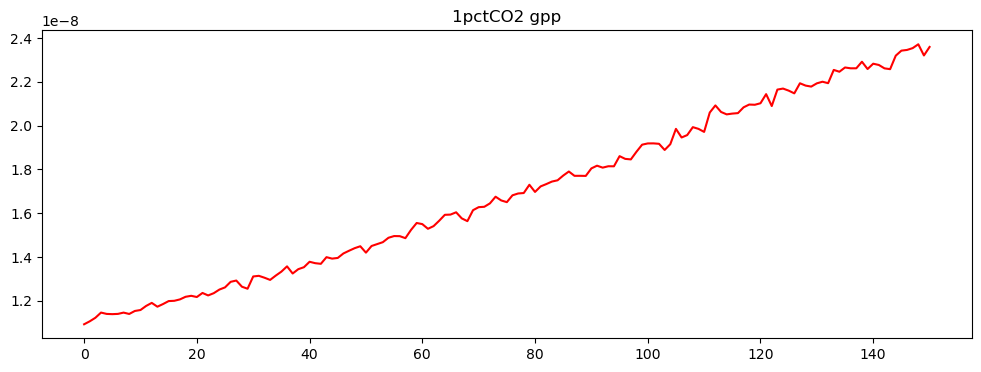

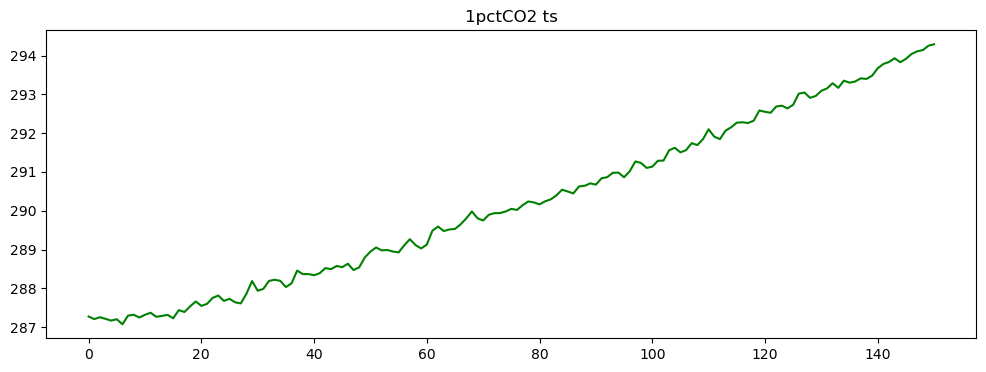

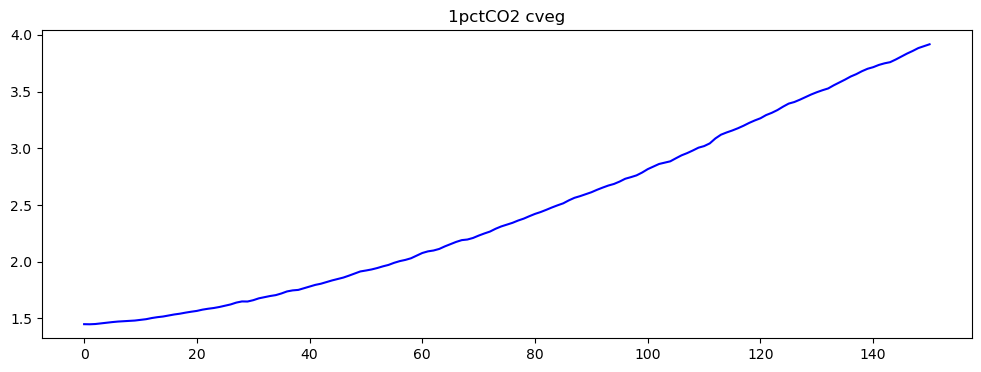

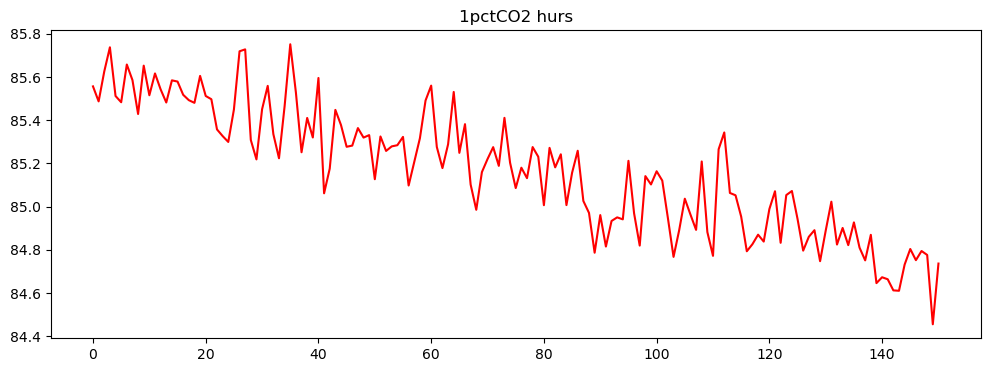

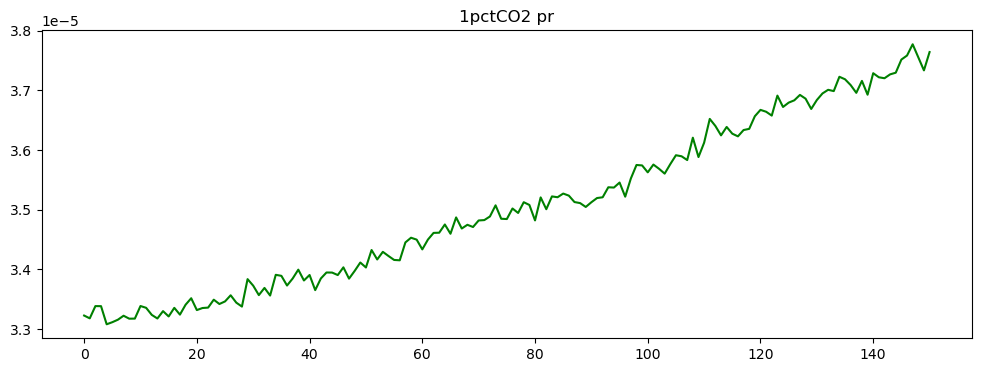

In [22]:
timeseries({
    "1pctCO2 gpp":"./gpp_Lmon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc",
    "1pctCO2 ts":"./ts_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc",
    "1pctCO2 cveg":"./cVeg_Lmon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc",
    "1pctCO2 hurs":"./hurs_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc",
    "1pctCO2 pr":"./pr_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc",
})

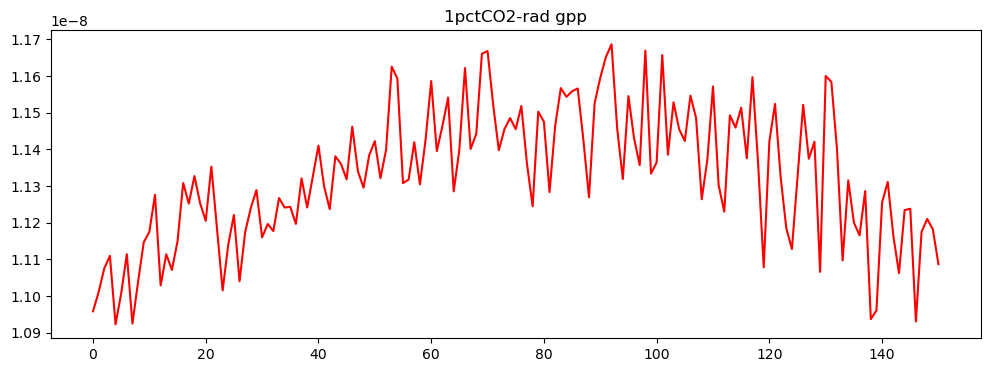

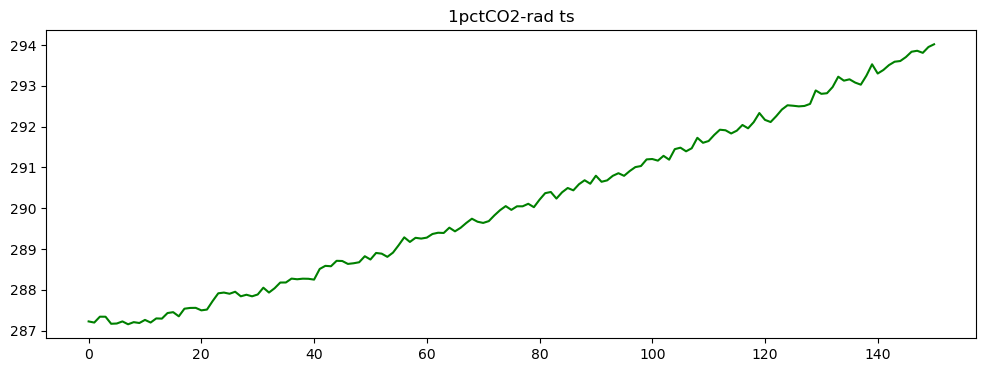

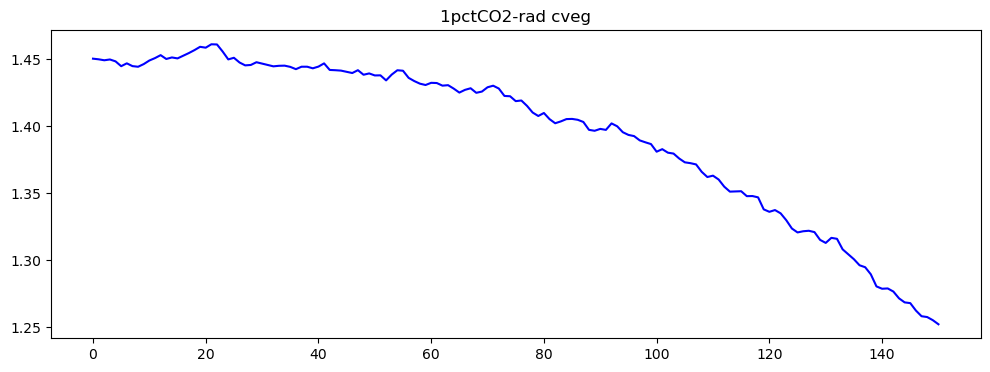

In [23]:
timeseries({
    "1pctCO2-rad gpp":"./gpp_Lmon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc",
    "1pctCO2-rad ts":"./ts_Amon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc",
    "1pctCO2-rad cveg":"./cVeg_Lmon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc",
})

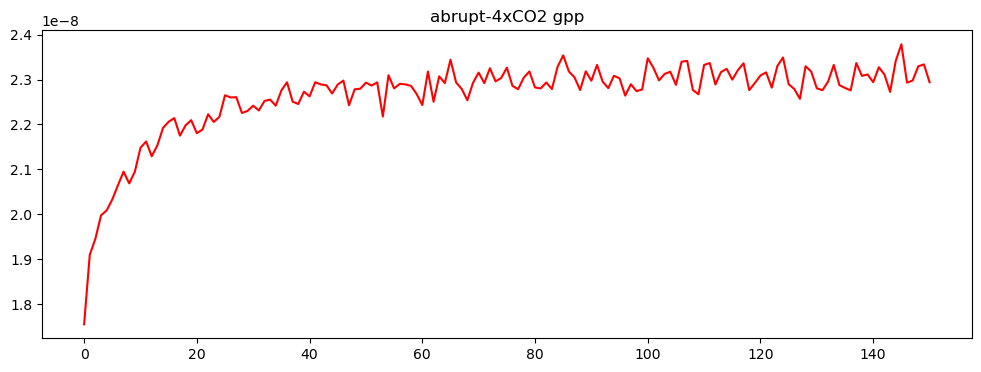

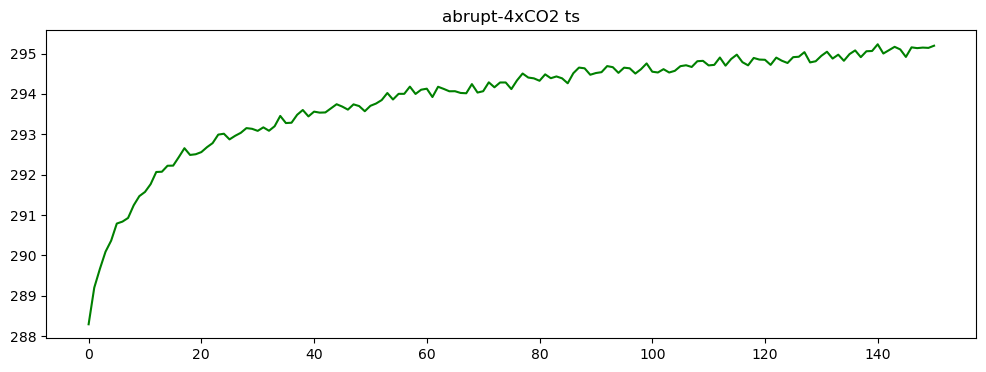

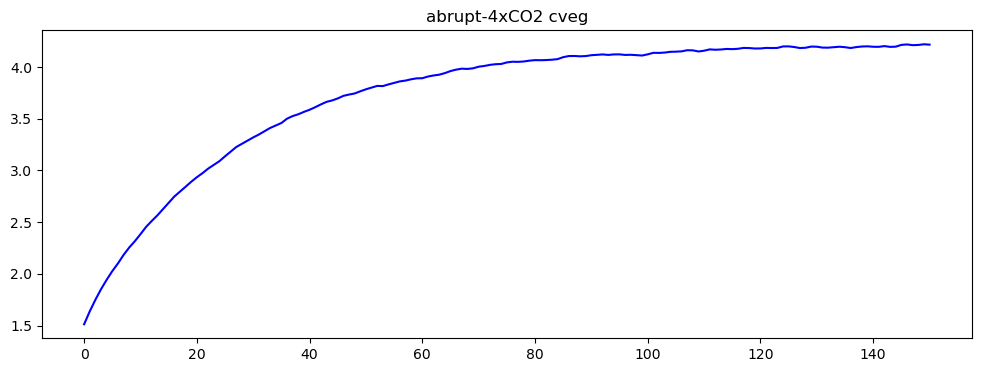

In [24]:
timeseries({
    "abrupt-4xCO2 gpp":"./gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p1f1_gn_185001-200012.nc",
    "abrupt-4xCO2 ts":"./ts_Amon_CanESM5_abrupt-4xCO2_r1i1p1f1_gn_185001-200012.nc",
    "abrupt-4xCO2 cveg":"./cVeg_Lmon_CanESM5_abrupt-4xCO2_r1i1p1f1_gn_185001-200012.nc",
})

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

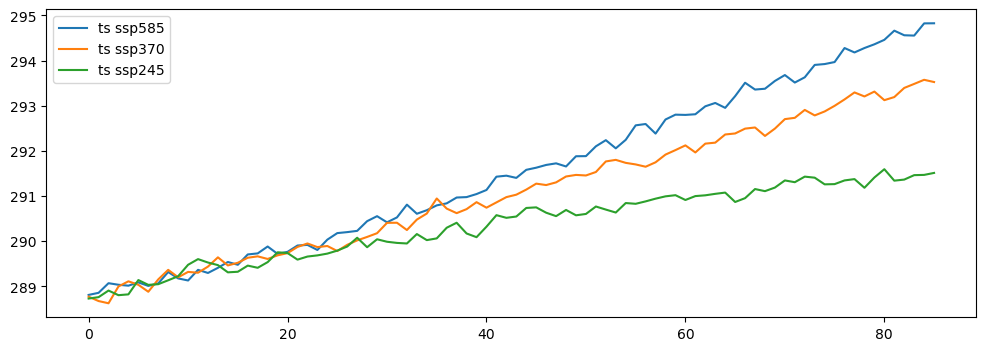

In [25]:
timeseries({
    "ts ssp585":"./ts_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc",
    "ts ssp370":"./ts_Amon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc",
    "ts ssp245":"./ts_Amon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.nc",
}, combined=True)
